This notebook has the goal of testing MFA-models, and determining if it is a good model choice. 
The notebook aims to test:
-   Model Complexity - Will the model be able to get a good BIC score and out-of-sample likelyhood
-   Reconstruction Fidelity - Calculate the reconstruction error in RMSE and SAM (Spectral Angle Mapper)
-   Interpretability - Does the components represent different and new signals
-   Class Interpretability - Assign a colour to each FA, and map the Hyperspectral image next to its rgb-image, do we see the same structures?  

In [1]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hypso import Hypso
from MFA import MFA
import pandas as pd
from utils import calculate_rmse, calculate_sam

# Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Loading the models, this includes the training statistics

In [2]:
# Load PCA
pca_checkpoint = torch.load('models/pca_benchmark.pt', map_location=device)
pca_components = pca_checkpoint['components'].to(device)
pca_mean = pca_checkpoint['mean'].to(device)

# Load MFA
mfa_checkpoint = torch.load('models/mfa_k2_q5.pt', map_location=device)
mfa_hyperparams = mfa_checkpoint['hyperparameters']

mfa_model = MFA(
    n_components=mfa_hyperparams['n_components'],
    n_features=mfa_hyperparams['n_features'],
    n_factors=mfa_hyperparams['n_factors'],
    device=device
)
mfa_model.load_state_dict(mfa_checkpoint['model_state_dict'])

# Extract MFA Preprocessing Stats
mfa_stats = mfa_checkpoint['preprocessing']
mfa_data_max = mfa_stats['data_max'].to(device)
mfa_data_mean = mfa_stats['mean'].to(device)

print("Models loaded successfully.")
print(f"MFA Config: K={mfa_hyperparams['n_components']}, q={mfa_hyperparams['n_factors']}")

Models loaded successfully.
MFA Config: K=2, q=5


Loading data, note that the models have differnet preprocessing steps

In [3]:
# Helper to load and preprocess a single file
def load_and_preprocess(filepath, model_type='mfa', mfa_stats=None, pca_mean=None, device='cpu'):
    satobj = Hypso(filepath)
    if satobj is None: return None
    
    raw = torch.tensor(satobj.l1a_cube.values, dtype=torch.float32).to(device)
    h, w, c = raw.shape
    flat_data = raw.reshape(-1, c)
    
    if model_type == 'mfa':
        # Scale 0-1 then center, using TRAINING stats
        scaled = flat_data / mfa_stats['data_max']
        processed = scaled - mfa_stats['mean']
    elif model_type == 'pca':
        # Just center using TRAINING mean
        processed = flat_data - pca_mean
        
    return processed, (h, w), satobj

# Search for test files (adjust path as needed)
test_files = glob.glob('data/testing/*.nc')
if not test_files:
    # Fallback if no testing folder exists, use a training file for demo purposes
    print("Warning: No test files found in data/testing. Using training data for demonstration.")
    test_files = glob.glob('data/training/*.nc')

# Merging the test-files into one file for testing

current_file = test_files[0]
print(f"Testing on: {current_file}")


# Load versions for both models
X_test_mfa, dims, satobj = load_and_preprocess(current_file, 'mfa', mfa_stats=mfa_stats, device=device)
X_test_pca, _, _ = load_and_preprocess(current_file, 'pca', pca_mean=pca_mean, device=device)

Testing on: data/testing\ijsselmeer_2024-10-22T09-53-08Z-l1a.nc


### Reconstruction Logic

In [4]:
# --- PCA Reconstruction ---
# Encode
z_pca = torch.matmul(X_test_pca, pca_components)
# Decode
X_rec_pca_centered = torch.matmul(z_pca, pca_components.T)
# De-process (Add mean)
X_rec_pca_final = X_rec_pca_centered + pca_mean

# --- MFA Reconstruction ---
def reconstruct_mfa(model, X):
    """
    Reconstructs X using the Component-Specific posterior expectation.
    """
    # 1. Get Responsibilities (Gamma) and local projections
    with torch.no_grad():
        # FIX 1: Swap variables. e_step returns (responsibilities, likelihood)
        log_resp, log_prob = model.e_step(X) 
        
        responsibilities = torch.exp(log_resp) 
        
        # Get cluster assignments
        cluster_ids = torch.argmax(responsibilities, dim=1)
        
        X_rec = torch.zeros_like(X)
        
        # FIX 2: Use model.K instead of model.n_components
        for k in range(model.K):
            # Indices belonging to cluster k
            mask = (cluster_ids == k)
            if mask.sum() == 0: continue
            
            X_k = X[mask]
            
            # Centered data for this component
            X_k_centered = X_k - model.mu[k]
            
            # FIX 3: Use model.Lambda instead of model.W
            Lambda = model.Lambda[k] 
            
            Psi_inv = torch.diag(1.0 / torch.exp(model.log_psi)) 
            
            # FIX 4: Use model.q instead of model.n_factors
            # Beta calc: beta = (I + L.T @ Psi_inv @ L)^-1 @ L.T @ Psi_inv
            M = torch.inverse(torch.eye(model.q, device=device) + Lambda.T @ Psi_inv @ Lambda)
            beta = M @ Lambda.T @ Psi_inv
            
            z_k = (X_k_centered @ beta.T)
            
            # Reconstruct
            X_rec_k = z_k @ Lambda.T + model.mu[k]
            X_rec[mask] = X_rec_k
            
    return X_rec, cluster_ids

# Run the fixed function
X_rec_mfa_processed, cluster_ids = reconstruct_mfa(mfa_model, X_test_mfa)

# De-process MFA (Add mean -> Scale back)
X_rec_mfa_final = (X_rec_mfa_processed + mfa_stats['mean']) * mfa_stats['data_max']

In [5]:
# Calculate Scores
rmse_pca = calculate_rmse(X_test_pca, X_rec_pca_final)
sam_pca = calculate_sam(X_test_pca, X_rec_pca_final)

rmse_mfa = calculate_rmse(X_test_mfa, X_rec_mfa_final)
sam_mfa = calculate_sam(X_test_mfa, X_rec_mfa_final)

print("=== Reconstruction Benchmark Results ===")
print(f"PCA (q={pca_components.shape[1]}): RMSE = {rmse_pca:.4f}, SAM = {sam_pca:.4f} rad")
print(f"MFA (K={mfa_model.K}, q={mfa_model.q}): RMSE = {rmse_mfa:.4f}, SAM = {sam_mfa:.4f} rad")
print("========================================")

=== Reconstruction Benchmark Results ===
PCA (q=3): RMSE = 17922.0469, SAM = 1.2590 rad
MFA (K=2, q=5): RMSE = 19612.2441, SAM = 1.3445 rad


### Class segmentation test

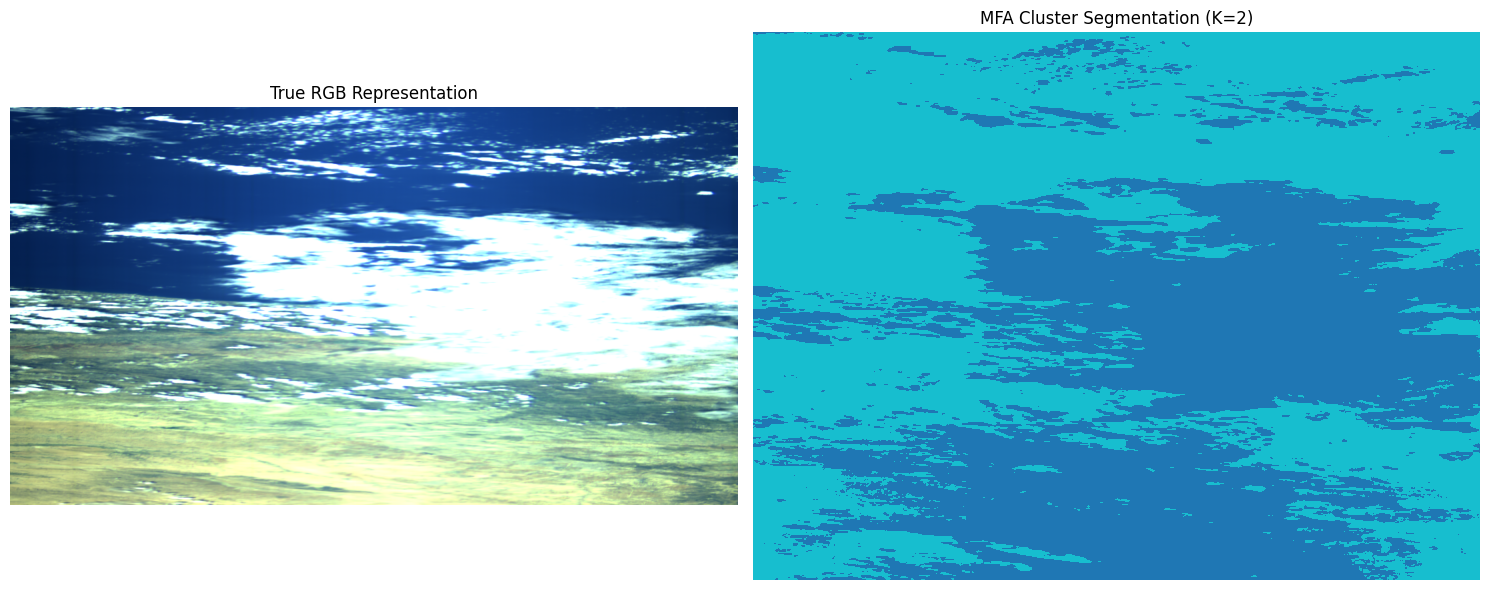

In [6]:
# Reshape clusters to image
h, w = dims
seg_map = cluster_ids.reshape(h, w).cpu().numpy()

# Get RGB for comparison (Bands 70, 50, 20 approx for Hypso)
rgb_bands = [70, 50, 20]
rgb_img = satobj.l1a_cube.values[:, :, rgb_bands]
# Normalize RGB for display
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(rgb_img)
ax[0].set_title("True RGB Representation")
ax[0].axis('off')

# Discrete colormap for clusters
sns.heatmap(seg_map, ax=ax[1], cmap="tab10", cbar=False)
ax[1].set_title(f"MFA Cluster Segmentation (K={mfa_model.K})")
ax[1].axis('off')

plt.tight_layout()
plt.show()

### Spectral Components

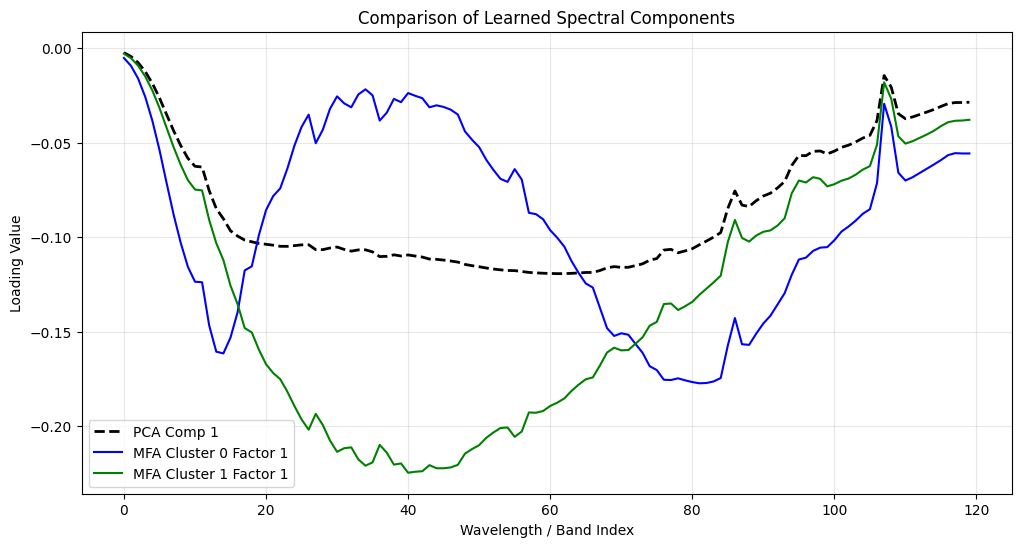

In [7]:
wavelengths = satobj.wavelengths if hasattr(satobj, 'wavelengths') else np.arange(120)

plt.figure(figsize=(12, 6))

# Plot PCA First Component
plt.plot(wavelengths, pca_components[:, 0].cpu().numpy(), 'k--', label='PCA Comp 1', linewidth=2)

# Plot MFA Component 1 for each cluster
colors = ['b', 'g', 'r', 'c']
for k in range(mfa_model.K):
    # Extract Factor Loading Matrix (Lambda) for cluster k
    # Shape (D, q), we take first factor
    loading = mfa_model.Lambda[k][:, 0].detach().cpu().numpy()
    plt.plot(wavelengths, loading, label=f'MFA Cluster {k} Factor 1', color=colors[k % len(colors)])

plt.xlabel("Wavelength / Band Index")
plt.ylabel("Loading Value")
plt.title("Comparison of Learned Spectral Components")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()